In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


caminhos do diretorio e a contagem das imagens que vamos usar para fazer o treinamento do modelo


In [2]:

dataset_dir = os.path.join(os.getcwd(), 'cat_and_dogs')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_cats_len = len(os.listdir(os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogs_len = len(os.listdir(os.path.join(dataset_train_dir, 'dogs')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_cats_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(os.path.join(dataset_validation_dir, 'dogs')))

print('Train Cats: %s' % dataset_train_cats_len)
print('Train Dogs: %s' % dataset_train_dogs_len)
print('Validation Cats: %s' % dataset_validation_cats_len)
print('Validation Dogs: %s' % dataset_validation_dogs_len)

Train Cats: 5324
Train Dogs: 4906
Validation Cats: 7176
Validation Dogs: 7594


variaveis de modelos e pre-processamento das imagens para treinamento, tamanaho, altura, largura e coloração.

In [3]:
width = 100  # width: largura da imagem que será utilizada pelo modelo (em pixels)
height = 100  # height: altura da imagem que será utilizada pelo modelo (em pixels)
color = 3 # color: número de canais de cor da imagem (3 para RGB)
color_size = 255 # valor máximo para cada canal de cor (255 para imagens de 8 bits)
size_image = (width, height) # tupla que define as dimensões da imagem (largura, altura) para o modelo
format_image = size_image + (color,) # tupla que define as dimensões da imagem incluindo o número de canais de cor (largura, altura, canais)
batch_size = 32 # número de imagens processadas em cada iteração durante o treinamento do model
epochs = 10 # vezes que o treinamento ira percorrer o dataset das imagens
learning_rate = 0.0001 # aprendizagem do modelo
string_values = ['gato', 'cachorro'] # melhorando a visualização do que é cada valor, onde 0 e gato e 1 e cachorro


Este código configura o ambiente para treinar um modelo de classificação de imagens de gatos e cachorros, Ele define os diretórios dos dados, conta a quantidade de imagens para treino e validação.

In [4]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_train_dir,
  batch_size=batch_size,
  image_size=size_image,
  shuffle=True,
)

Found 10230 files belonging to 2 classes.


dataset_validation configura o ambiente para validar o modelo de treinamento de imagens de gatos e cachorros, conta a quantidade de imagens para validação do treinamento do modelo acima.

In [5]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_validation_dir,
  batch_size=batch_size,
  image_size=(width, height),
  shuffle=True,
)

Found 14770 files belonging to 2 classes.


In [6]:
dataset_validation_size = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_size // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('validacao: %d' % tf.data.experimental.cardinality(dataset_validation))
print('teste: %d' % tf.data.experimental.cardinality(dataset_test))

validacao: 370
teste: 92


In [7]:
autotune = tf.data.AUTOTUNE

dataset_train = dataset_train.prefetch(buffer_size = autotune)
dataset_validation = dataset_validation.prefetch(buffer_size = autotune)
dataset_test = dataset_validation.prefetch(buffer_size = autotune)

In [8]:
def plot_dataset(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, labels in dataset.take(1):

        for i in range(9):

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(string_values[labels[i]])

visualização de algumas imagens do dataset_train, que sera usado para treinar o modelo de rede neural.

<Figure size 640x480 with 0 Axes>

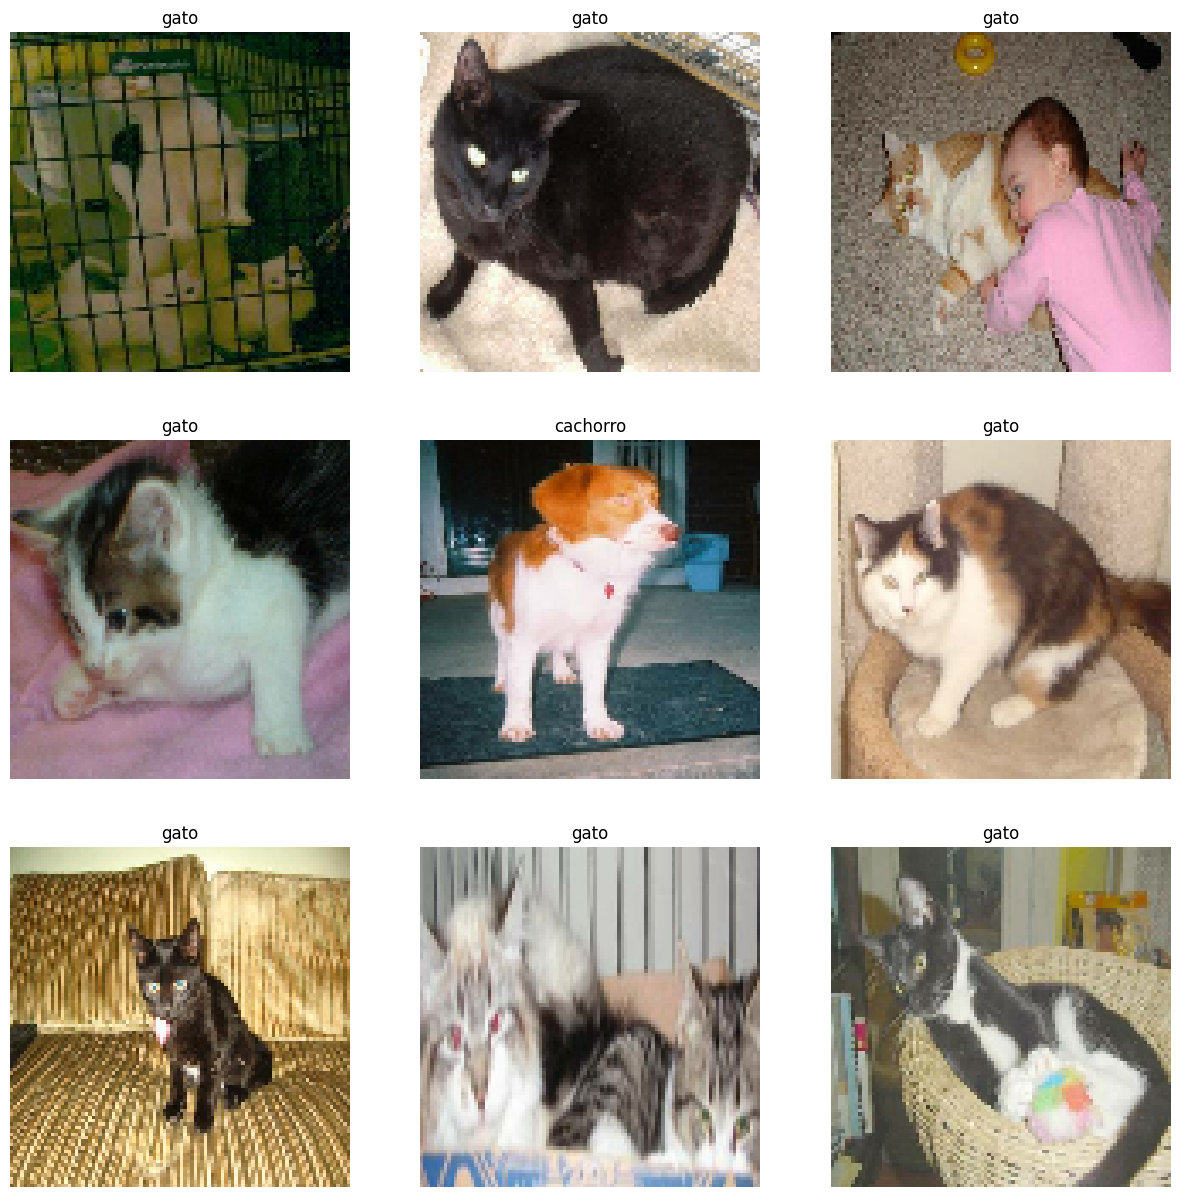

In [9]:
plot_dataset(dataset_train)

visualização de algumas imagens do dataset_validation, que sera usado para validar o dataset_train durante sua execução.

<Figure size 640x480 with 0 Axes>

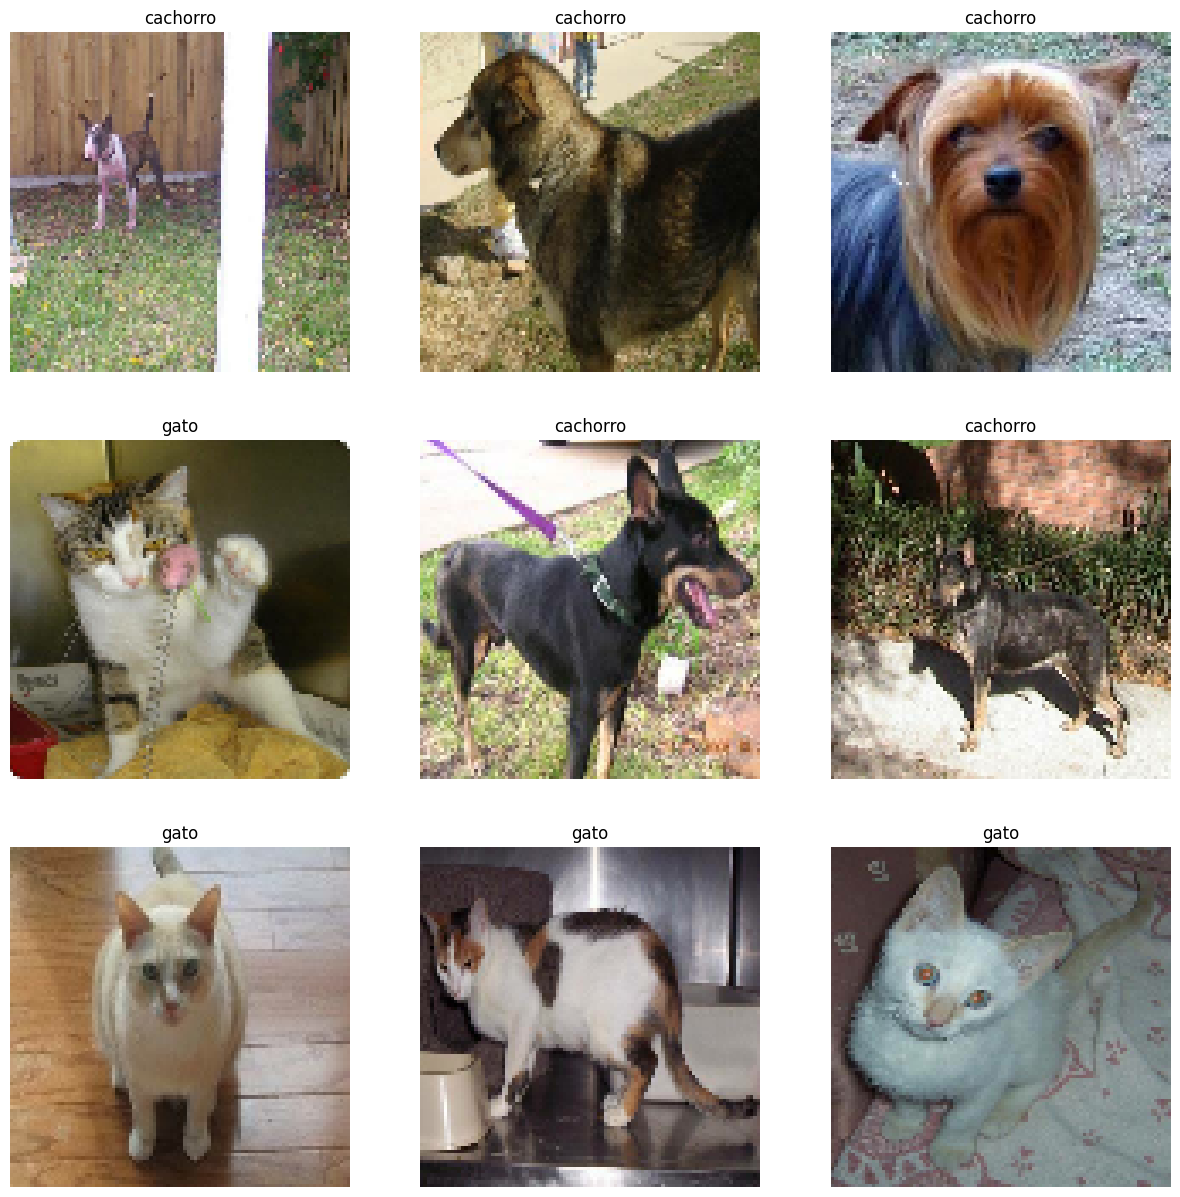

In [10]:
plot_dataset(dataset_validation)

visualização de algumas imagens do dataset_test, que sera usado para testar a accuracy e loss do dataset_train

<Figure size 640x480 with 0 Axes>

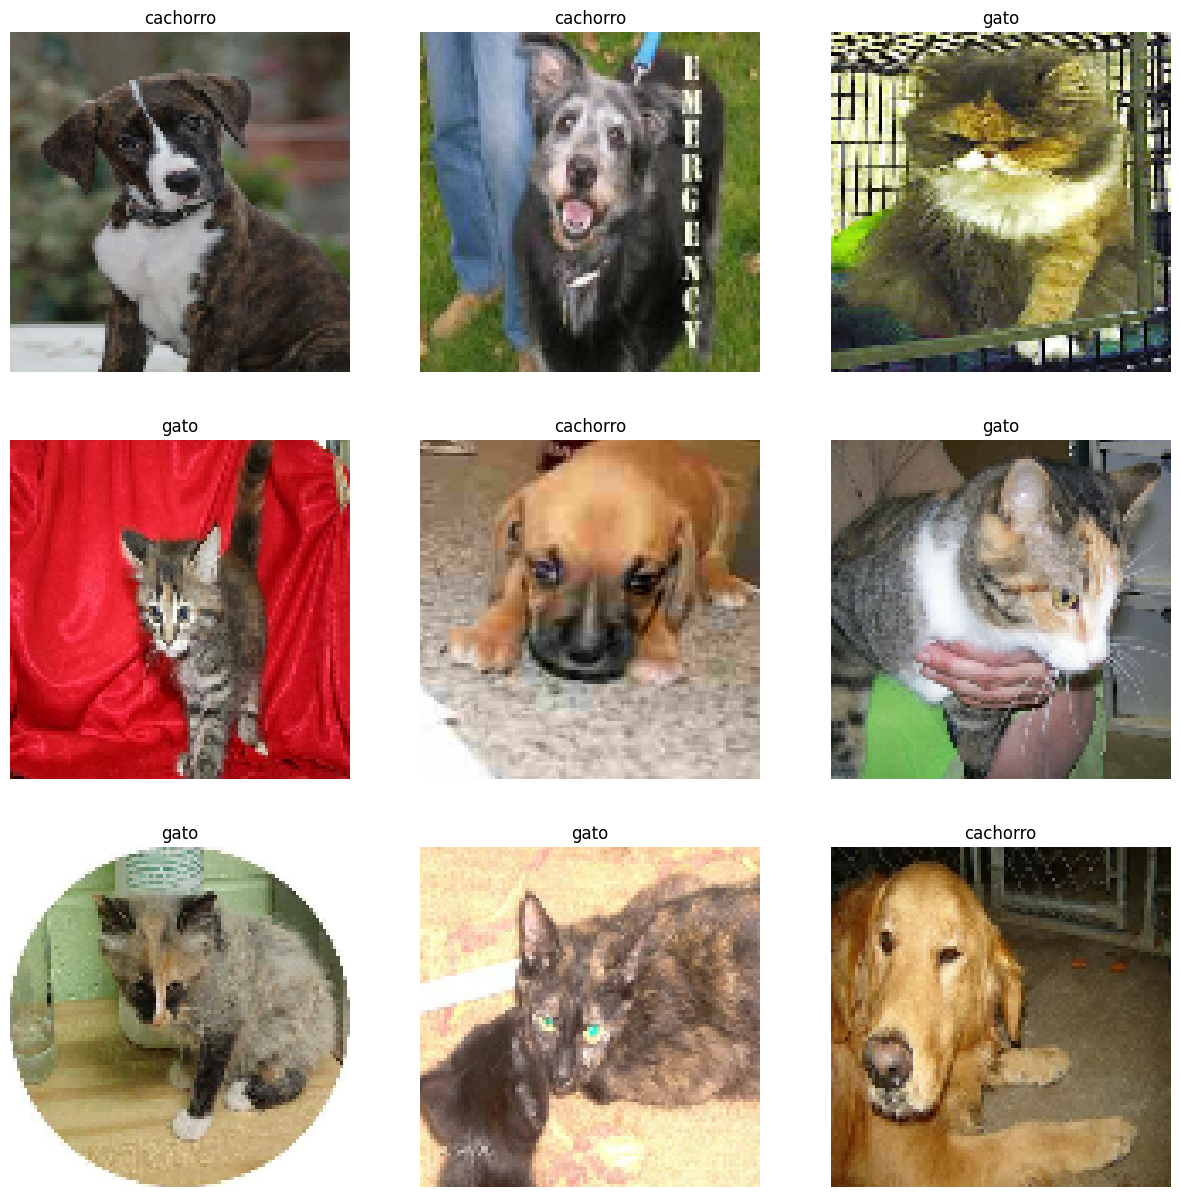

In [11]:
plot_dataset(dataset_test)

modelo de rede neural sequencial:

1. Pre-processamento:
  - Rescaling: Normaliza os valores dos pixels das imagens para o intervalo [0, 1], dividindo por color_size (255).

2. Camadas Convolucionais:
  - Três blocos de Conv2D seguidos por MaxPooling2D:
    - Conv2D: Extrai características das imagens usando filtros de convolução (16, 32 e 64 filtros, respectivamente).
    - **MaxPooling2D**: Reduz a dimensionalidade espacial das características extraídas.

3. Camada de Flatten:
  - Transforma os dados 2D em um vetor 1D para entrada na camada totalmente conectada.

4. Camadas Densas:
  - Dense(128, activation=relu): Aprende padrões complexos nas caracteristicas extraidas.
  - Dense 1, activation = sigmoid: Produz uma saída entre 0 e 1 para classificaçao binaria

O modelo é configurado para receber imagens com formato format_image e        treinada para dizer se a imagem é de um gato ou cachorro. 

5. Funcao Adam: 
  - funçao otimizada para buscarmos o melhor resultado e o menor erro possivel do modelo treinado, passando tambem o parametro learnig_rate, variavel feita nas configurações da terceira celula desse codigo.  

6. Funcao BinaryCrossentropy: 
  - função de custo otimizada quando o resulatdo e binario/boleano (O ou 1, GATO ou CACHORRO) 

7. Metrics: 
  - precisao de acertividade do modelo treinado.

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / color_size,
        input_shape = format_image
    ),
    tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        1

treinamento do modelo passando os parametros de cofiguração
dataset_train,
epochs
e dataset_validation

In [13]:
history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_validation
)

Epoch 1/10
320/320 [==============================] - 107s 333ms/step - loss: 0.6520 - accuracy: 0.6047 - val_loss: 0.5889 - val_accuracy: 0.6924
Epoch 2/10
320/320 [==============================] - 102s 317ms/step - loss: 0.5582 - accuracy: 0.7174 - val_loss: 0.5541 - val_accuracy: 0.7172
Epoch 3/10
320/320 [==============================] - 102s 320ms/step - loss: 0.5159 - accuracy: 0.7494 - val_loss: 0.5302 - val_accuracy: 0.7338
Epoch 4/10
320/320 [==============================] - 112s 349ms/step - loss: 0.4939 - accuracy: 0.7639 - val_loss: 0.5096 - val_accuracy: 0.7492
Epoch 5/10
320/320 [==============================] - 98s 307ms/step - loss: 0.4695 - accuracy: 0.7829 - val_loss: 0.4956 - val_accuracy: 0.7631
Epoch 6/10
320/320 [==============================] - 91s 283ms/step - loss: 0.4486 - accuracy: 0.7924 - val_loss: 0.4851 - val_accuracy: 0.7678
Epoch 7/10
320/320 [==============================] - 83s 261ms/step - loss: 0.4296 - accuracy: 0.8030 - val_loss: 0.5138 - va

função para mapear compartameno do dataset que ele nao foi treinado.

In [20]:
def graph_dataset_analysis(dataset):

  news, labels = dataset.as_numpy_iterator().next()

  views = model.predict_on_batch(news).flatten()
  views = tf.where(views < 0.5, 0, 1)

  print('Real: ', labels)
  print('Pred: ', views.numpy())
  print('\n')
  
  plt.gcf().clear()
  plt.figure(figsize = (15, 15))

  for i in range(9):

      plt.subplot(3, 3, i + 1)
      plt.axis('off')

      plt.imshow(news[i].astype('uint8'))
      plt.title(string_values[views[i]])
      plt.title(string_values[labels[i]]) 

resultado da analise do treinamento usando o dataset_test

Real:  [0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1]
Pred:  [0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0]




<Figure size 640x480 with 0 Axes>

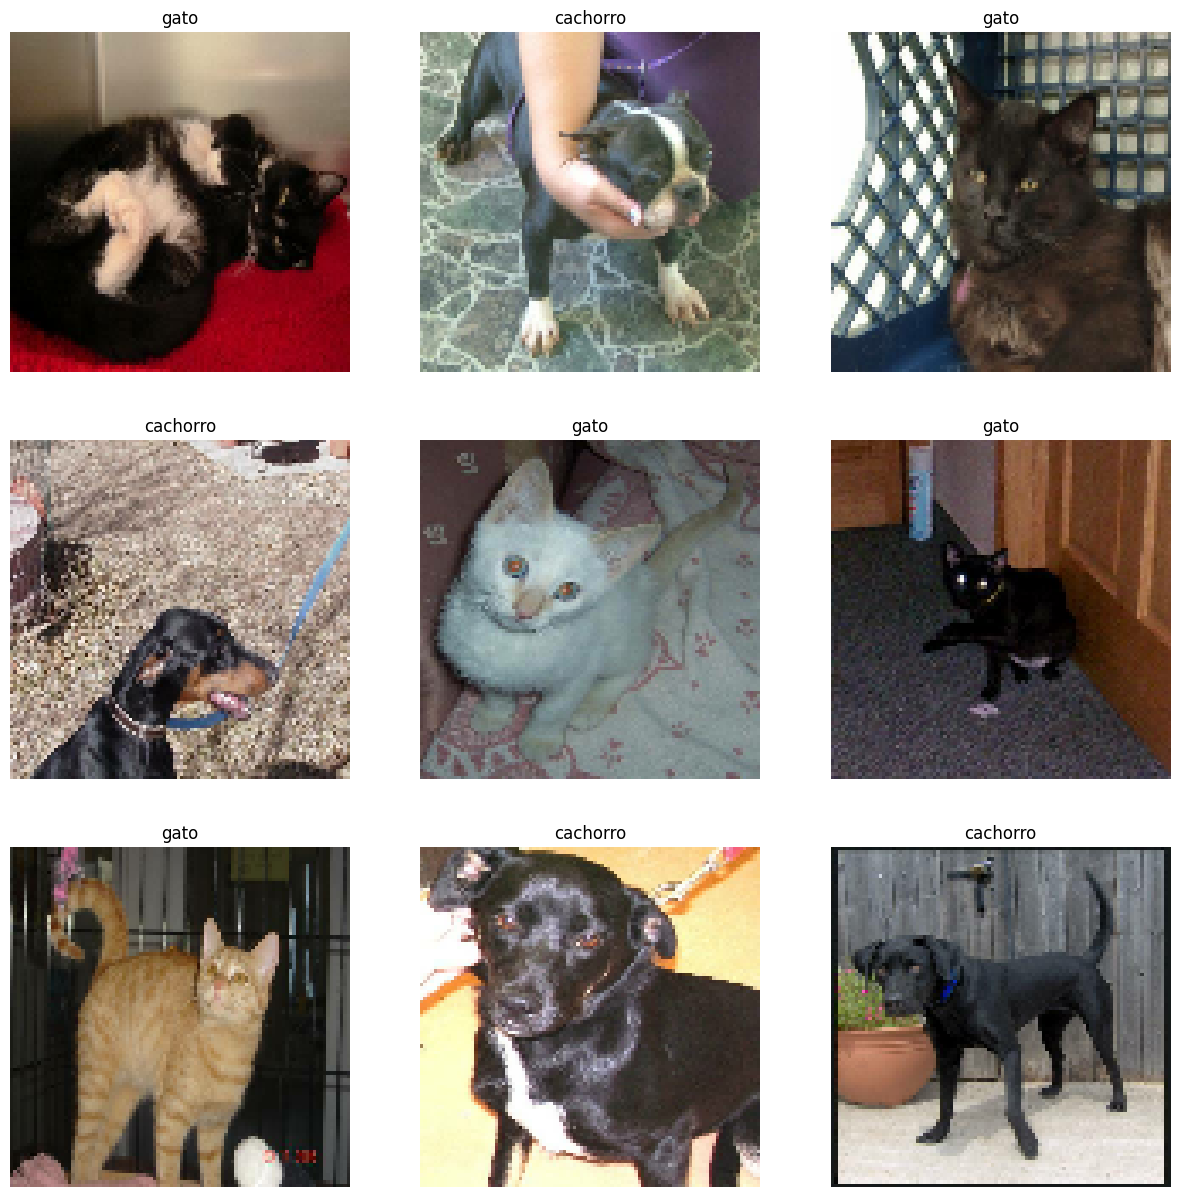

In [21]:
graph_dataset_analysis(dataset_test)

salvando modelo

In [16]:
model.save('path/to/model')

INFO:tensorflow:Assets written to: path/to/model\assets


INFO:tensorflow:Assets written to: path/to/model\assets


carregado modelo

In [17]:
model = tf.keras.models.load_model('path/to/model')

mas e agora??, como saber a performance desse modelo? como saber o comportamento se esta bom ou ruim e quais parametros podemos melhorar?

montaremos uma funçao que monitora o desempenho de accuracy e validation

In [18]:
def behavior_model():

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  range_epochs = range(epochs)

  plt.gcf().clear()
  plt.figure(figsize = (15, 15))

  plt.subplot(1, 2, 1)
  plt.title('comportamento de accuracy e validation')
  plt.plot(range_epochs, accuracy, label = 'train_accuracy')
  plt.plot(range_epochs, val_accuracy, label = 'val_accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.title('comportamento de loss e validation')
  plt.plot(range_epochs, loss, label = 'train_loss')
  plt.plot(range_epochs, val_loss, label = 'val_loss')
  plt.legend(loc='lower right')

  plt.show()

execução da função bahavior_model

ao visualizarmos a analise do modelo, nota-se que o modelo tem um overfitting, mas afinal oque é? em um breve resumo seria que o modelo tem uma precisao melhor com dados que foi treinado, entretanto nao tem uma precisao tao boa com dados fora da sua base de treinamento.

<Figure size 640x480 with 0 Axes>

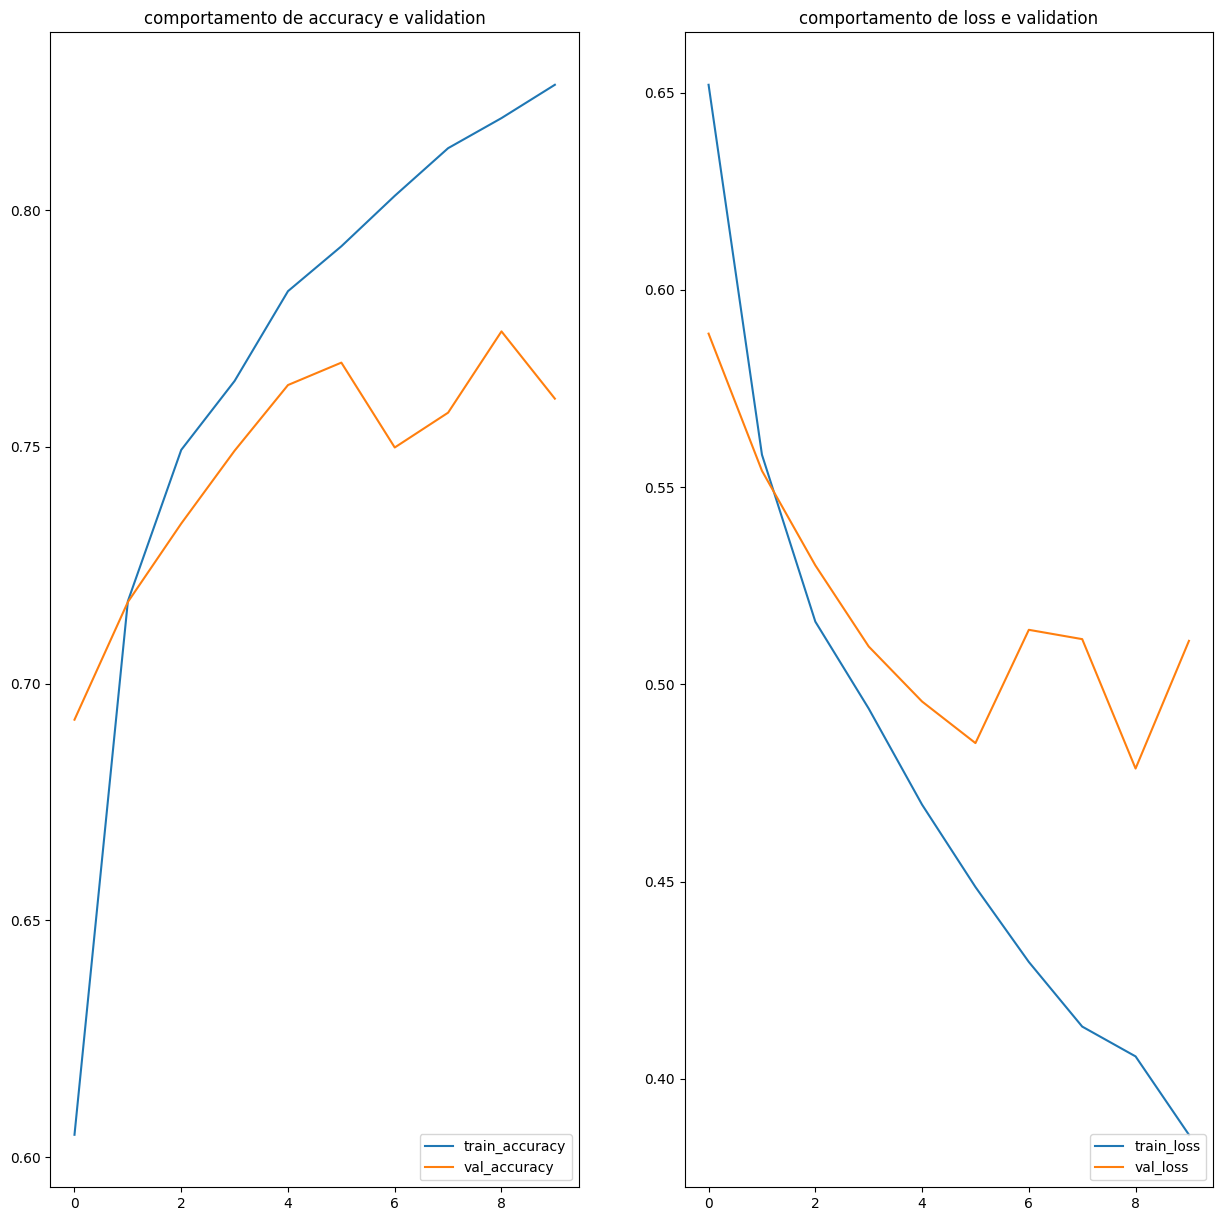

In [22]:
behavior_model()